In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomFlip, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
#import cv2
import logging
import warnings
import json

In [1]:
#Suppress warnings from the logging module
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

NameError: name 'logging' is not defined

In [23]:
#Tensorflow Version
print(tf.__version__)

2.10.0


In [24]:
#Check if any GPU devices are detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
else:
    print("No GPU detected.")

GPUs detected: 1


In [25]:
#Set seed
SEED = 385153

#Global variables
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_classes = 18 # Number of folders in dataset
AUTOTUNE = tf.data.AUTOTUNE

In [32]:
# get chat to rename this shit and mix it up

#Load Dataset
dataset_dir = 'hagdata/hagridset'
full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    seed=SEED,
    image_size=(IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

#Split into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

##Total length of the dataset
total_size = len(full_ds)

#Compute indices for the splits
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - (train_size + val_size)

##Split the dataset and shuffle
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED)
test_ds = full_ds.skip(train_size + val_size).shuffle(test_size, seed=SEED)

#Cache the dataset in memory (or use a directory to store it on disk if necessary)
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = full_ds.skip(train_size + val_size).cache().prefetch(buffer_size=AUTOTUNE)

#Count samples in each subset
def count_samples(dataset):
    sample_count = sum(1 for _ in dataset.unbatch())
    return sample_count

#Output the number of samples for each dataset
print(f'Using {count_samples(train_ds)} samples in the Training set')
print(f'Using {count_samples(val_ds)} samples in the Validation set')
print(f'Using {count_samples(test_ds)} samples in the Test set')

Found 125912 files belonging to 18 classes.
Using 88128 samples in the Training set
Using 12576 samples in the Validation set
Using 25208 samples in the Test set


In [31]:
#Get class names
class_names = full_ds.class_names
class_names

['call',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

In [33]:
#Define the Light CNN Model from Scratch
def build_scratch_cnn_light_tuned(): # build_ ***rename***
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

    # model.add(data_augmentation_layers)

    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values

    model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    # model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile your model with an initial learning rate
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )

    return model    

#Instantiate and summarize the lighter model
scratch_model_light_tuned = build_scratch_cnn_light_tuned() # rename scratch_model_light_tuned
scratch_model_light_tuned.summary() # rENAME TO TO[PEW]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0

In [34]:
# ask chat to put all of this into on method


#Define a learning rate schedule
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + 0.01 * epoch)

#Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    LearningRateScheduler(lr_time_based_decay, verbose=1)
]


#Train the model
history_light_tuned = scratch_model_light_tuned.fit( # rename history_light_tuned -- same as model name
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks  # Include both callbacks here
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 75s 22ms/step - loss: 1.7468 - accuracy: 0.4433 - val_loss: 1.2092 - val_accuracy: 0.6264 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 62s 22ms/step - loss: 0.9190 - accuracy: 0.7049 - val_loss: 0.8152 - val_accuracy: 0.7486 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 68s 25ms/step - loss: 0.6894 - accuracy: 0.7785 - val_loss: 0.7576 - val_accuracy: 0.7599 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 70s 25ms/step - loss: 0.5716 - accuracy: 0.8180 - val_loss: 0.5813 - val_accuracy: 0.8190 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler 

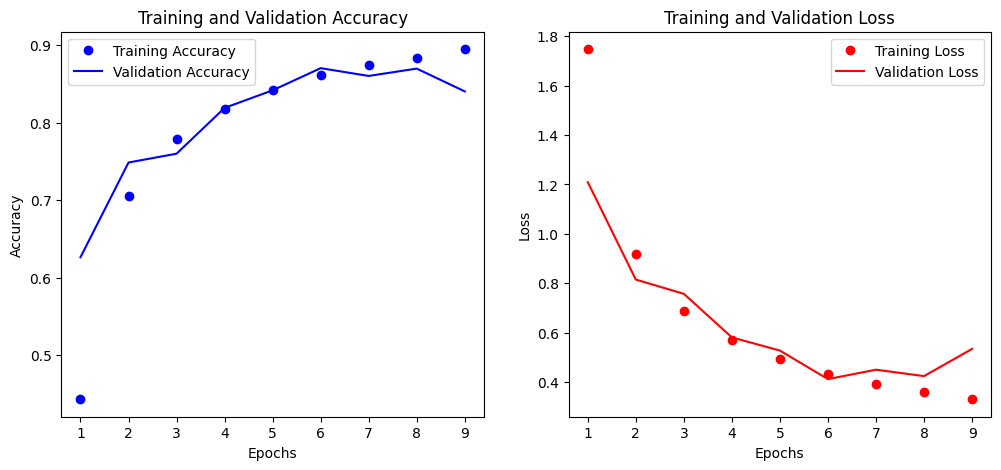

In [35]:
#change colours and change both graphs to both use lines

#Access the history dictionary
acc = history_light_tuned.history['accuracy']
val_acc = history_light_tuned.history['val_accuracy']
loss = history_light_tuned.history['loss']
val_loss = history_light_tuned.history['val_loss']

#Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

#Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

#Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()

ASK CHAT

I need the loss and accuracy along with inference time of my models results

Take that model, make it greyscale, and test it. It'll be very similar to the model you have.

It'll require you to load, spilt, shuffle and cache the dataset as greyscale. You can use the original data loading code I gave you to do this. Give it to chat and say you need it to make it greyscale.

You have a good model,copy and re-make it as greyscale, then do 2 VGG-16 models and you are good. Data Augmentation should only be done for one model (as it takes so fucking long so choose whichever one you want) OR you could just do a copy of the first model and do it with data augmentation as well
[1:57 AM]
The key is to rename all the models differently so they dont get confused

In [ ]:
#Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    # DO ONE OR OTHER
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])